In [1]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input,Lambda
from keras import backend as K
from keras.models import Model
from keras.layers import Dense,Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Conv2DTranspose,Reshape,concatenate,Reshape
from keras.layers.normalization import BatchNormalization
from keras import losses
from keras.optimizers import Adam
import cv2
from tqdm import tqdm

/home/meirtz/miniconda3/envs/dl35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
%matplotlib inline
input_size = 384
latent_dim = 128
num_data=8189
cwd='/home/meirtz/explore/CuoNet/Data/flowers/jpg/'

In [3]:
def getWandH():
    f=open(cwd+'files.txt')
    sumx=0
    sumy=0
    for i in range(1,num_data+1):
        name=f.readline()[0:-1]
        x=plt.imread(cwd+name)
        sumx+=x.shape[0]
        sumy+=x.shape[1]
    return sumx//num_data,sumy//num_data
image_h,image_w=getWandH()

In [3]:
def processing(image):
    new_image=cv2.resize(image/255., (input_size,input_size))
    return new_image
def processing_out(image):
    new_image=cv2.resize(image/255., (input_size//2,input_size//2))
    return new_image
def dataprepare():
    for i in tqdm(range(1,num_data+1)):
        if i<10:
            name='image_0000'+str(i)+'.jpg'
        elif i<100:
            name='image_000'+str(i)+'.jpg'
        elif i<1000:
            name='image_00'+str(i)+'.jpg'
        else:
            name='image_0'+str(i)+'.jpg'
        image=plt.imread(cwd+name)
        x[i-1]=processing(image)
        #x_out[i-1]=processing_out(image)

In [4]:
x=np.empty((num_data,input_size,input_size,3),dtype='float32')
dataprepare()

100%|██████████| 8189/8189 [01:24<00:00, 97.48it/s]


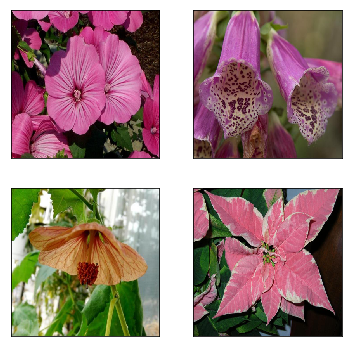

In [5]:
idx = np.random.randint(0, num_data, size=36)
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(6,6),)
for ii, ax in zip(idx, axes.flatten()):
    ax.imshow((x[ii]), aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0.2, hspace=0.2)

In [6]:
def kk_block(X,num_filter):
    #3*3+3*3
    X1 = Conv2D(num_filter,(3, 3), padding='same')(X)
    X1 = BatchNormalization()(X1)
    X1 = Activation("relu")(X1)
    X1 = Conv2D(num_filter,(3, 3), padding='same',strides=(2,2))(X1)
    X1 = BatchNormalization()(X1)
    X1 = Activation("relu")(X1)
    
    #1*1+3*3
    X2 = Conv2D(num_filter,(1, 1), padding='same')(X)
    X2 = BatchNormalization()(X2)
    X2 = Activation("relu")(X2)
    X2 = Conv2D(num_filter,(3, 3), padding='same',strides=(2,2))(X2)
    X2 = BatchNormalization()(X2)
    X2 = Activation("relu")(X2)
    
    out= concatenate([X1,X2],axis=-1)
    return out
def aver(arg):
    x1,x2=arg
    return (x1+x2)/2
def half_1(x):
    half=x.shape[3]//2
    return x[:,:,:,0:half]
def half_2(x):
    half=x.shape[3]//2
    return x[:,:,:,half:x.shape[3]]
def kk_block_T(X,num_filter):
    X1 = Lambda(half_1)(X)
    X1 = Conv2DTranspose(num_filter,(3, 3), padding='same')(X1)
    X1 = BatchNormalization()(X1)
    X1 = Activation("relu")(X1)
    X1 = Conv2DTranspose(num_filter,(3, 3), strides=(2, 2),padding='same')(X1)
    X1 = BatchNormalization()(X1)
    X1 = Activation("relu")(X1)
    
    
    X2 = Lambda(half_2)(X)
    X2 = Conv2DTranspose(num_filter,(1, 1), padding='same')(X2)
    X2 = BatchNormalization()(X2)
    X2 = Activation("relu")(X2)
    X2 = Conv2DTranspose(num_filter,(3, 3), strides=(2, 2),padding='same')(X2)
    X2 = BatchNormalization()(X2)
    X2 = Activation("relu")(X2)
    
    out= Lambda(aver)([X1,X2])
    return out

In [ ]:
net_input = Input(shape=(input_size,input_size,3))
X = Conv2D(16,(3, 3), padding='same',activation='relu')(net_input)
X = Conv2D(16,(3, 3), padding='same',activation='relu')(X)
X = MaxPooling2D((2, 2))(X)
X = kk_block(X,32)
X = kk_block(X,64)
X = kk_block(X,128)
X = kk_block(X,256)
X = kk_block(X,512)
X = kk_block(X,1024)
hidden=Conv2D(latent_dim,(3, 3), padding='valid')(X)
hidden=BatchNormalization()(hidden)
decoder_input = Conv2DTranspose(2048,(3, 3),padding='valid',activation='relu')(hidden)
X = kk_block_T(decoder_input,1024)
X = kk_block_T(X,512)
X = kk_block_T(X,256)
X = kk_block_T(X,128)
X = kk_block_T(X,64)
X = kk_block_T(X,32)
X = Conv2DTranspose(16,(3, 3), strides=(2, 2),padding='same')(X)
X = Conv2DTranspose(16,(3, 3), padding='same',activation='relu')(X)
out = Conv2DTranspose(3,(3, 3), padding='same',activation='relu')(X)
net = Model(net_input, out)
net.summary()

In [7]:
def GenFlower_loss(x_origin,x_out):
    x_origin=K.flatten(x_origin)
    x_out=K.flatten(x_out)
    loss = losses.binary_crossentropy(x_origin, x_out)
    return loss
optimizers=Adam(0.0001,0.5)
net.compile(optimizer=optimizers, loss=GenFlower_loss)

NameError: name 'net' is not defined

In [80]:
import os
if os.path.exists('my_model_weights.h5'):
    net.load_weights('my_model_weights.h5')

In [ ]:
epochs=10000
batch_size=36
print_interval=50
for epoch in range(epochs):
    idx = np.random.randint(0, x.shape[0],batch_size)
    imgs = x[idx]
    # Train the discriminator (real classified as ones and generated as zeros)
    loss = net.train_on_batch(imgs,imgs)
    print ("%d [loss: %f]" % (epoch, loss))
    if epoch%print_interval==0:
        fig, axes = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(10,10),)
        i=0
        idx = np.random.randint(0, x.shape[0],4)
        gen_imgs=net.predict(x[idx])
        for ax in axes.flatten():
            ax.imshow( np.clip(gen_imgs[i], 0., 1.) , aspect='equal')
            i+=1
            ax.xaxis.set_visible(False)
            ax.yaxis.set_visible(False)
            plt.subplots_adjust(wspace=0.2, hspace=0.2)
        plt.show()

In [38]:
import keras.callbacks  
keras.callbacks.EarlyStopping(monitor='train_loss',patience=3,verbose=0,mode='auto')  
epochs = 300
batch_size = 32
net.fit(x,x,shuffle=True,
        epochs=epochs,
        batch_size=batch_size)


Epoch 1/300
1360/1360 [==============================] - 21s 15ms/step - loss: 0.0225
Epoch 2/300
1360/1360 [==============================] - 21s 15ms/step - loss: 0.0223
Epoch 3/300
1360/1360 [==============================] - 21s 16ms/step - loss: 0.0216
Epoch 4/300
1360/1360 [==============================] - 21s 16ms/step - loss: 0.0218
Epoch 5/300
1360/1360 [==============================] - 21s 16ms/step - loss: 0.0211
Epoch 6/300
1360/1360 [==============================] - 21s 15ms/step - loss: 0.0210
Epoch 7/300
1360/1360 [==============================] - 21s 15ms/step - loss: 0.0205
Epoch 8/300
1360/1360 [==============================] - 21s 15ms/step - loss: 0.0205
Epoch 9/300
1360/1360 [==============================] - 21s 15ms/step - loss: 0.0203
Epoch 10/300
1360/1360 [==============================] - 21s 15ms/step - loss: 0.0199
Epoch 11/300
1360/1360 [==============================] - 21s 15ms/step - loss: 0.0196
Epoch 12/300
1360/1360 [============================

KeyboardInterrupt: 

In [85]:
net.save_weights('my_model_weights.h5')

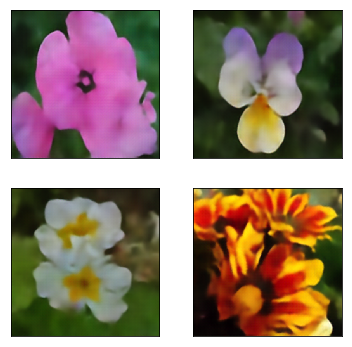

In [78]:
idx = np.random.randint(0, num_data, size=36)
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(6,6),)
x_out=net.predict(x[idx])
i=0
for ii, ax in zip(idx, axes.flatten()):
    ax.imshow( np.clip(x_out[i], 0., 1.) , aspect='equal')
    i+=1
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0.2, hspace=0.2)

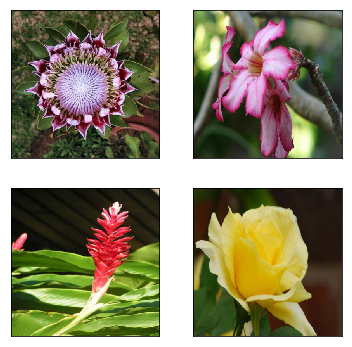

In [47]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(6,6),)
for ii, ax in zip(idx, axes.flatten()):
    ax.imshow( x[ii] , aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0.2, hspace=0.2)

In [75]:
for i, layer in enumerate(net.layers):
    print(i, layer.name)

0 input_10
1 conv2d_136
2 conv2d_137
3 max_pooling2d_6
4 conv2d_138
5 conv2d_140
6 batch_normalization_270
7 batch_normalization_272
8 activation_265
9 activation_267
10 conv2d_139
11 conv2d_141
12 batch_normalization_271
13 batch_normalization_273
14 activation_266
15 activation_268
16 concatenate_31
17 conv2d_142
18 conv2d_144
19 batch_normalization_274
20 batch_normalization_276
21 activation_269
22 activation_271
23 conv2d_143
24 conv2d_145
25 batch_normalization_275
26 batch_normalization_277
27 activation_270
28 activation_272
29 concatenate_32
30 conv2d_146
31 conv2d_148
32 batch_normalization_278
33 batch_normalization_280
34 activation_273
35 activation_275
36 conv2d_147
37 conv2d_149
38 batch_normalization_279
39 batch_normalization_281
40 activation_274
41 activation_276
42 concatenate_33
43 conv2d_150
44 conv2d_152
45 batch_normalization_282
46 batch_normalization_284
47 activation_277
48 activation_279
49 conv2d_151
50 conv2d_153
51 batch_normalization_283
52 batch_normali

In [76]:
decoder_input=Input(shape=(1,1,latent_dim))
decoder=net.layers[84](decoder_input)
X = kk_block_T(decoder,1024)
X = kk_block_T(X,512)
X = kk_block_T(X,256)
X = kk_block_T(X,128)
X = kk_block_T(X,64)
X = kk_block_T(X,32)
X = Conv2DTranspose(16,(3, 3), strides=(2, 2),padding='same')(X)
X = Conv2DTranspose(16,(3, 3), padding='same',activation='relu')(X)
out = Conv2DTranspose(3,(3, 3), padding='same',activation='relu')(X)
Decoder=Model(decoder_input,out)
Decoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, 1, 1, 128)    0                                            
__________________________________________________________________________________________________
conv2d_transpose_168 (Conv2DTra (None, 3, 3, 2048)   2361344     input_17[0][0]                   
__________________________________________________________________________________________________
lambda_127 (Lambda)             (None, 3, 3, 1024)   0           conv2d_transpose_168[6][0]       
__________________________________________________________________________________________________
lambda_128 (Lambda)             (None, 3, 3, 1024)   0           conv2d_transpose_168[6][0]       
__________________________________________________________________________________________________
conv2d_tra

In [77]:
for i in range(1,95):
    Decoder.layers[i].set_weights(net.layers[i+83].get_weights())

KeyboardInterrupt: 

In [56]:
latent = Model(inputs=net.input,outputs=net.layers[83].output)  
latent_out = latent.predict(x[1000].reshape([1,384,384,3]))  
print(latent_out)

[[[[-0.09654605 -1.7344115   0.11384058  0.4090431   0.4785821
     0.5897379   0.24910356 -0.00658524 -0.03004497  0.6426805
     0.7479414   0.36597896  0.7529297  -0.73696053 -0.10623402
     0.24219179  0.08444524 -0.35384417 -0.73573893 -0.25807393
     0.41120893 -0.9718685   2.0608082  -0.5256269   0.34811422
    -0.18456164 -0.7790923   0.7464056   0.7898448   0.56946677
     1.2093047  -0.85506797  0.7001732  -0.5587191  -0.43498406
     0.3423285  -0.36243534  0.01491489 -0.58265615 -0.55712616
    -1.0067565   0.54321176 -0.8833125  -0.07157911 -0.77404535
     1.4836588   0.5757443   1.7069324  -0.54375863 -1.0322675
    -1.7184409  -1.4603412  -0.08688487 -1.00817     0.30910993
     0.1574505  -0.30025047 -0.01060081  0.5115625   1.7410011
    -0.5601269  -0.3432413  -0.04333711 -0.20215854  0.12283695
     0.08771233  0.5394941   1.7439167  -2.6255841  -0.26361817
     0.68332434  0.10687919  0.83777213  0.8249775   0.3740247
     0.51321816 -0.52433604 -0.3527521   0.60

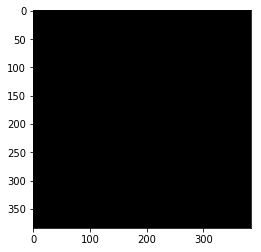

In [57]:
random_input=np.random.rand(1,1,1,128)*4-2
out=Decoder.predict(latent_out).reshape([384,384,3])
plt.imshow(np.clip(out,0,1))

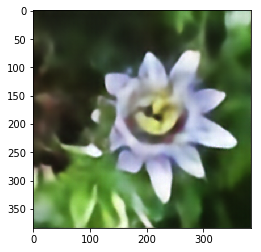

In [63]:
out=net.predict(x[2:5]).reshape([3,384,384,3])
plt.imshow(np.clip(out[2],0,1))